# Network Analysis Project
## Crime Network Analysis
Professor: Michele Coscia

This notebook contains all of the code developed for the Network Analysis Course at ITU. We will be using...**finish**

**Add Description**

Group 10:  
Carl August Wismer ([cwis@itu.dk](mailto:cwis@itu.dk))  <br>
Crisanna Cornish ([ccor@itu.dk](mailto:ccor@itu.dk))  <br>
Danielle Dequin ([ddeq@itu.dk](mailto:ddeq@itu.dk))  <br>
Maria Do Carmo Madeira Santos Silva Passos de Sousa ([mdom@itu.dk](mailto:mdom@itu.dk))  <br>
Moneeca Abru Iftikhar Latif ([abml@itu.dk](mailto:abml@itu.dk))  <br>
Sabrina Fonseca Pereira ([sabf@itu.dk](mailto:sabf@itu.dk))  <br>

Created: 27-09-2021  
Last Modified: 19-11-2021

# Data Source

The data are a network of associations among suspects, victims, and/or witnesses involved in crimes in St. Louis in the 1990s. Data are derived from police records, via snowball sampling from five initial homicides. Left nodes are people, right nodes are crime events, and edges connect people to particular crimes events they were associated with. Metadata includes names, genders, and roles (suspects, victims, and/or witnesses).

This is an undirected, unweighted, bipartite network with 1380 nodes and 1476 edges.

Data can be downloaded [here](http://konect.cc/networks/moreno_crime/) or [here](https://networks.skewed.de/net/crime).

# Imports

In [1]:
import numpy as np
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
from scipy.stats import linregress
import powerlaw as pl
from scipy.optimize import curve_fit
import re


# PATHS

In [2]:
DATA = '../Data/out.moreno_crime_crime'
ROLE = '../Data/rel.moreno_crime_crime.person.role'
NAME = '../Data/ent.moreno_crime_crime.person.name'
SEX =  '../Data/ent.moreno_crime_crime.person.sex'

# Constants

# Functions

In [3]:
def f(x, a, l):
    """A custom function which is a power law with its exponential truncation. From 'Atlas for the Aspiring
    Network Scientist' Chapter 6
    """
    return (x ** a) * np.exp(-l * x) 

def log_f(x, a, l):
    """The Logarithm of f, used to fit the log of the CCDF using curve_fit"""
    return np.log10(f(x, a, l))

# Load Data

In [4]:
with open(DATA) as f:
    data = f.read().splitlines()
    
with open(ROLE) as f:
    role = f.read().splitlines()
    
with open(NAME) as f:
    name = f.read().splitlines()
    
with open(SEX) as f:
    sex = f.read().splitlines()
    
for i in range(len(data)):
    data[i] = 'p' + data[i] # adds 'p' to the People nodes to differentiate them

In [5]:
lasts = []
firsts = []
for n in name:
    lasts.append((re.findall('[A-Z][^A-Z]*', n))[0])
    firsts.append((re.findall('[A-Z][^A-Z]*', n))[1])

In [6]:
B = nx.read_edgelist(data) # read edgelist in
print(len(B.nodes()), len(B.edges())) # sanity check (1380, 1476)

1380 1476


In [7]:
graph = np.loadtxt(DATA, dtype=str)
a = np.unique(graph[:,0]) # people nodes
b = np.unique(graph[:,1]) # crime nodes
a = ['p' + a for a in a] # add string to differentiate

print(f"There are {len(a)} unique people and {len(b)} unique crime events.")

There are 829 unique people and 551 unique crime events.


## Create Graph

In [8]:
G = nx.Graph()

# add nodes
for j in range(len(a)):
    #G.add_node(a[j], bipartite=0, data=True, name=name[j], sex=sex[j]) # Add attributes name and sex
    G.add_node(a[j], bipartite=0, data=True, name=name[j], first=firsts[j], last=lasts[j], sex=sex[j]) #Add attributes name and sex
    
G.add_nodes_from(b, bipartite=1, data=True)

# add edges
i = 0
for edge in B.edges():
    G.add_edge(edge[0], edge[1], role= [role[i]])
    
    i+=1

In [9]:
# sanity check
print(
    'Num. of nodes: {} \nNum. of edges: {} \nIs bipartite? {} \nIs connected? {}'.format(
        G.number_of_nodes(), 
        G.number_of_edges(), 
        nx.is_bipartite(G),
        nx.is_connected(G)
        )
    )

Num. of nodes: 1380 
Num. of edges: 1476 
Is bipartite? True 
Is connected? False


From the [official Networkx docs](https://networkx.org/documentation/stable/reference/algorithms/bipartite.html):

Many algorithms of the bipartite module of NetworkX require, as an argument, a container with all the nodes that belong to one set, in addition to the bipartite graph B. The functions in the bipartite package do not check that the node set is actually correct nor that the input graph is actually bipartite. If B is connected, you can find the two node sets using a two-coloring algorithm:

```py
>>> nx.is_connected(B)
True
>>> bottom_nodes, top_nodes = bipartite.sets(B)
```
However, if the input graph is not connected, there are more than one possible colorations. This is the reason why we require the user to pass a container with all nodes of one bipartite node set as an argument to most bipartite functions. In the face of ambiguity, we refuse the temptation to guess and raise an AmbiguousSolution Exception if the input graph for bipartite.sets is disconnected.

Using the bipartite node attribute, you can easily get the two node sets:

In [10]:
top_nodes = {n for n, d in G.nodes(data=True) if d["bipartite"] == 0} # people
bottom_nodes = set(G) - top_nodes      # crimes

## Adding Metadata to Nodes

In [11]:
print(nx.get_node_attributes(G, 'name')['p1']) # check name of person 'p1' = 'AbelDennis'
print(nx.get_node_attributes(G, 'sex')['p1']) # check sex of person 'p1' = '1'
print(nx.get_edge_attributes(G, 'role')['p1', '1']) # check role of edge between person p1 and crime 1 = 'Suspect'

AbelDennis
1
['Suspect']


### Add "Criminal Status" node attribute to each people node

**Here, we are making the assumption that, if a person has been involved in a crime as a "suspect" or "victim suspect" then they are a criminal. Meanwhile, if someone has only been a "witness" or a "victim" then they are "innocent".**

In [12]:
# Initialize a dictionary based on people nodes to keep track of all roles per node
p_nodes = {el:[] for el in top_nodes}
# Add all the edge attributes to a dictionary of people nodes
for key,value in nx.get_edge_attributes(G, 'role').items():
    for part in key:
        if part in top_nodes:
            p_nodes[part].append(value[0])
print(p_nodes['p1'])
print(p_nodes['p815'])

# Initialize a dictionary to keep track of who is a "criminal"
criminals = {el:[] for el in top_nodes}
# Loop through all roles per node, and deem them criminals if ever they have been a suspect
for key in p_nodes:
    for value in p_nodes[key]:
        if value == "Suspect":
            criminals[key] = "Criminal"
            break
        elif value == "Victim Suspect":
            criminals[key] = "Criminal"
            break
        else:
            criminals[key] = "Innocent"
print(criminals['p1']) # Should be a Criminal

# Convert to pandas df
criminals_df = pd.DataFrame(criminals.items(), columns=['node', 'Criminal_Status'])
# loop through rows in the data frame and add the attribute of Criminal Status
for index, row in criminals_df.iterrows():
    #print(row['node'])
    G.nodes[row['node']]['Criminal_Status'] = row['Criminal_Status']

print(nx.get_node_attributes(G, 'Criminal_Status')['p1']) # check name of person 'p1' = 'Criminal'
print(nx.get_node_attributes(G, 'Criminal_Status')['p815']) # check name of person 'p1' = 'Criminal'

['Suspect', 'Victim', 'Victim', 'Suspect']
['Victim', 'Victim', 'Victim', 'Suspect', 'Victim', 'Victim', 'Suspect', 'Victim', 'Victim', 'Suspect', 'Suspect', 'Suspect', 'Victim', 'Victim', 'Witness', 'Suspect', 'Suspect', 'Suspect', 'Suspect', 'Victim', 'Suspect', 'Suspect', 'Suspect', 'Victim', 'Witness']
Criminal
Criminal
Criminal


In [13]:
#nx.get_edge_attributes(G, 'role')

# Finding Largest Connected Components

In [14]:
# Components in the graph sorted in descendent order
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)

# Selecting the biggest component
G0 = G.subgraph(Gcc[0])

In [15]:
# Create lists of nodes for the LCC
top_nodes_lcc = {n for n, d in G0.nodes(data=True) if d["bipartite"] == 0} # people
bottom_nodes_lcc = set(G0) - top_nodes_lcc      # crimes

In [16]:
# Number of nodes for each component and number of components
comp_list = []
for comp in Gcc:
    comp_len = len(comp)
    comp_list.append(comp_len)

f'Number of nodes for each components {comp_list} and number of components {len(comp_list)}'

'Number of nodes for each components [1263, 30, 18, 13, 9, 7, 6, 5, 4, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2] and number of components 20'

# Exploratory Data Analysis (EDA)

### Average Clustering

In [17]:
print('Density: {} \nAverage Clustering: {}'.format(
        round(bipartite.density(G, bottom_nodes),5), 
        round(bipartite.average_clustering(G),5)
    )
)
print('\n')
print('Density LCC: {} \nAverage Clustering LCC: {}'.format(
        round(bipartite.density(G0, bottom_nodes_lcc),5), 
        round(bipartite.average_clustering(G0),5)
    )
)

Density: 0.00323 
Average Clustering: 0.42748


Density LCC: 0.00359 
Average Clustering LCC: 0.42404


### Another way to get Average Clustering

In [18]:
cluster = bipartite.clustering(G)
print(f'Clustering of Entire Network: {round(sum(cluster.values())/len(cluster.values()),5)}')

cluster2 = bipartite.clustering(G0)
print(f'Clustering for LCC: {round(sum(cluster2.values())/len(cluster2.values()),5)}')

Clustering of Entire Network: 0.42748
Clustering for LCC: 0.42404


### Global Clustering

In [19]:
# This is the entire graph
global_clustering = bipartite.robins_alexander_clustering(G)
print(f'Global Clustering: {round(global_clustering,5)}')

# This is for only the LCC
global_clustering_lcc = bipartite.robins_alexander_clustering(G0)
print(f'Global Clustering LCC: {round(global_clustering_lcc, 5)}')

Global Clustering: 0.05047
Global Clustering LCC: 0.05124


**EXPLANATION OF CLUSTERING:** TO BE DONE BY SOMEONE

# Nodes stats

## Betweenneess Centrality

In [20]:
# For the Whole network
betweenness_centrality = bipartite.betweenness_centrality(G, top_nodes)

# For the LCC
betweenness_centrality_lcc = bipartite.betweenness_centrality(G0, top_nodes_lcc)

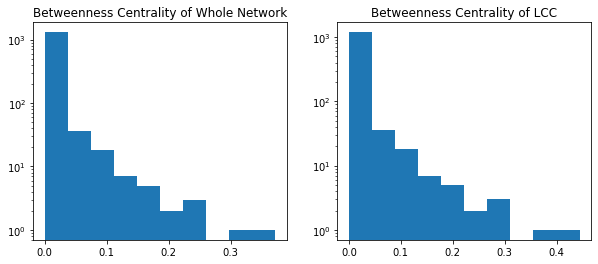

In [21]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
ax1.set_title('Betweenness Centrality of Whole Network')
ax2.set_title('Betweenness Centrality of LCC')
ax1.hist(betweenness_centrality.values(), bins=10, log=True)
ax2.hist(betweenness_centrality_lcc.values(), bins=10, log=True)
plt.show();

## Closeness Centrality

In [22]:
# For the Whole Network
closeness_centrality = bipartite.closeness_centrality(G, top_nodes)

# For the LCC
closeness_centrality_lcc = bipartite.closeness_centrality(G0, top_nodes_lcc)

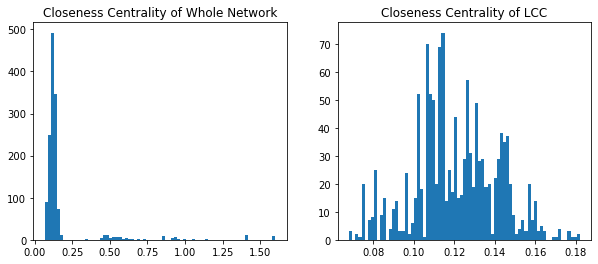

In [23]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
ax1.set_title('Closeness Centrality of Whole Network')
ax2.set_title('Closeness Centrality of LCC')
ax1.hist(closeness_centrality.values(), bins=75)
ax2.hist(closeness_centrality_lcc.values(), bins=75)
plt.show();

In [24]:
# People node with the most neighbors (Max left degree)
node_neighbors = {n: len(set(G.neighbors(n))) for n in top_nodes}
maxnode = max(node_neighbors, key = node_neighbors.get)
print(maxnode, node_neighbors[maxnode])

# People node in LCC with most neighbors
node_neighbors_lcc = {n: len(set(G0.neighbors(n))) for n in top_nodes_lcc}
maxnode_lcc = max(node_neighbors_lcc, key = node_neighbors_lcc.get)
print(maxnode_lcc, node_neighbors_lcc[maxnode_lcc])

p815 25
p815 25


In [25]:
# Crime node with the most neighbors (Max right degree)
node_neighbors = {n: len(set(G.neighbors(n))) for n in bottom_nodes}
maxnode = max(node_neighbors, key = node_neighbors.get)
print(maxnode, node_neighbors[maxnode])

node_neighbors_lcc = {n: len(set(G0.neighbors(n))) for n in bottom_nodes_lcc}
maxnode_lcc = max(node_neighbors_lcc, key = node_neighbors_lcc.get)
print(maxnode_lcc, node_neighbors_lcc[maxnode_lcc])

110 18
110 18


**ADD EXPLANATION**

## Degree Distribution

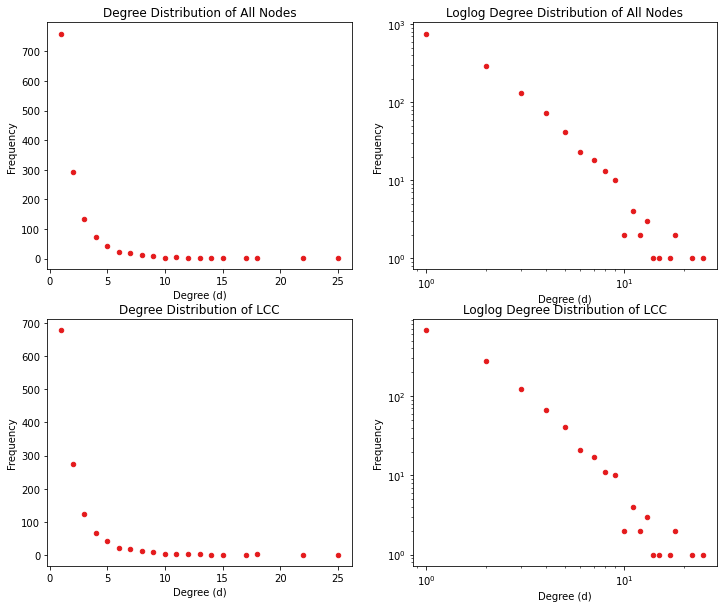

In [26]:
# Degree Distribution of the Entire Network, Combining People and Crime Nodes
dd = Counter(dict(G.degree).values())
dd = pd.DataFrame(list(dd.items()), columns = ("Degree (d)", "Frequency")).sort_values(by = "Degree (d)")

# Degree Distribution of the LCC, Combining People and Crime Nodes
dd_lcc = Counter(dict(G0.degree).values())
dd_lcc = pd.DataFrame(list(dd_lcc.items()), columns = ("Degree (d)", "Frequency")).sort_values(by = "Degree (d)")

fig, axs = plt.subplots(2,2, figsize=(12,10)) 
dd.plot(kind = "scatter", x = "Degree (d)", y = "Frequency", ax=axs[0,0], color = "#e41a1c", title="Degree Distribution of All Nodes")
dd.plot(kind = "scatter", x = "Degree (d)", y = "Frequency", ax=axs[0,1], color = "#e41a1c", loglog = True, title="Loglog Degree Distribution of All Nodes")

dd_lcc.plot(kind = "scatter", x = "Degree (d)", y = "Frequency", ax=axs[1,0], color = "#e41a1c", title="Degree Distribution of LCC")
dd_lcc.plot(kind = "scatter", x = "Degree (d)", y = "Frequency", ax=axs[1,1], color = "#e41a1c", loglog = True, title="Loglog Degree Distribution of LCC")
#plt.savefig("../Report/degree_distributions.png")
plt.show()

## People VS Crime Node Degree Distribution

(829, 551)

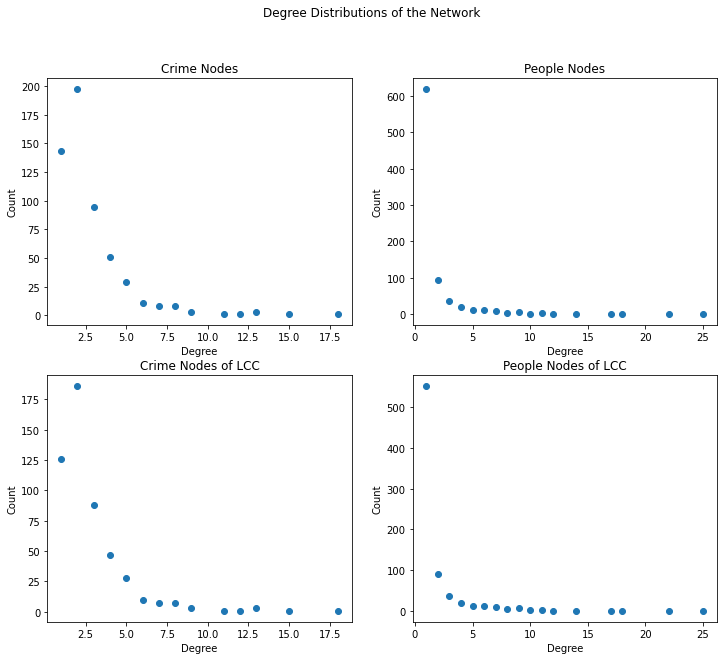

In [27]:
# This includes the entire graph
e_p = []
e_c = []
for k in G.nodes(): # Loop through all nodes
    if G.nodes[k]["bipartite"] == 0: # If People Nodes
        e_p.append(len(G.edges(k)))  # Append number of edges to each node
    else:                            # If Crime Nodes
        e_c.append(len(G.edges(k)))  # Append number of edges to each crime

e_cc = Counter(e_c)
e_pp = Counter(e_p)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(12,10))
fig.suptitle('Degree Distributions of the Network')

ax1.scatter(e_cc.keys(), e_cc.values())
ax1.set_title('Crime Nodes')
ax1.set_xlabel('Degree')
ax1.set_ylabel('Count')

ax2.scatter(e_pp.keys(), e_pp.values())
ax2.set_title('People Nodes')
ax2.set_xlabel('Degree')
ax2.set_ylabel('Count');

# This only deals with the LCC
# Lists of number of edges per node
e_p1 = [] # Number of edges connected to each People node
e_c1 = [] # Number of edges connected to each Crime node
for k in G0.nodes(): # loop through all nodes
    if G0.nodes[k]["bipartite"] == 0:  # If People Node
        e_p1.append(len(G0.edges(k)))  # Append number of edges to each node
    else:                              # If Crime Node
        e_c1.append(len(G0.edges(k)))  # Append number of edges to each node

e_cc1 = Counter(e_c1)
e_pp1 = Counter(e_p1)

#fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
#fig.suptitle('Degree Distributions of the Largest Connected Component')

ax3.scatter(e_cc1.keys(), e_cc1.values())
ax3.set_title('Crime Nodes of LCC')
ax3.set_xlabel('Degree')
ax3.set_ylabel('Count')

ax4.scatter(e_pp1.keys(), e_pp1.values())
ax4.set_title('People Nodes of LCC')
ax4.set_xlabel('Degree')
ax4.set_ylabel('Count');
len(e_p), len(e_c)

## CCDF

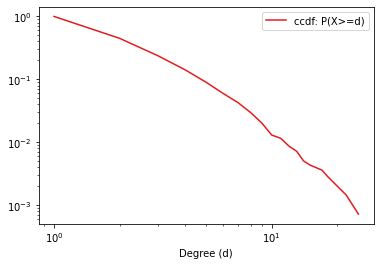

In [28]:
# Cumulative Degree distribution
ccdf = dd.sort_values(by = "Degree (d)", ascending = False)
ccdf["cumsum"] = ccdf["Frequency"].cumsum()
ccdf["ccdf: P(X>=d)"] = ccdf["cumsum"] / ccdf["Frequency"].sum()
ccdf = ccdf[["Degree (d)", "ccdf: P(X>=d)"]].sort_values(by = "Degree (d)")

ccdf.plot(kind = "line", x = "Degree (d)", y = "ccdf: P(X>=d)", color = "#e41a1c", loglog = True)
#plt.savefig("../Report/degree_distribution_ccdf.png")
plt.show()

## Fit CCDF to PowerLaw

In [29]:
logcdf = np.log10(ccdf[["Degree (d)", "ccdf: P(X>=d)"]])
slope, log10intercept, r_value, p_value, std_err = linregress(logcdf["Degree (d)"], logcdf["ccdf: P(X>=d)"])
print("CCDF Fit: %1.4f x ^ %1.4f (R2 = %1.4f, p = %1.4f)" % (10 ** log10intercept, slope, r_value ** 2, p_value))
print("\n")

results = pl.Fit(ccdf["ccdf: P(X>=d)"])
k_min = ccdf[ccdf["ccdf: P(X>=d)"] == results.power_law.xmin]["Degree (d)"]
print("Powerlaw CCDF Fit: %1.4f x ^ -%1.4f (k_min = %d)" % (10 ** results.power_law.Kappa, results.power_law.alpha, k_min))

CCDF Fit: 2.4953 x ^ -2.2984 (R2 = 0.9663, p = 0.0000)


Calculating best minimal value for power law fit
Powerlaw CCDF Fit: 11.5112 x ^ -1.4393 (k_min = 18)


<AxesSubplot:xlabel='Degree (d)'>

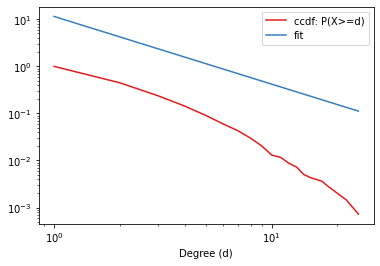

In [30]:
# Plot the best fit.
ccdf["fit"] = (10 ** results.power_law.Kappa) * (ccdf["Degree (d)"] ** -results.power_law.alpha)
ax = plt.gca()
ccdf.plot(kind = "line", x = "Degree (d)", y = "ccdf: P(X>=d)", color = "#e41a1c", loglog = True, ax = ax)
ccdf.plot(kind = "line", x = "Degree (d)", y = "fit", color = "#377eb8", loglog = True, ax = ax)
#plt.savefig("../Report/ccdf_fit.png")

## Degree Distributions Per Node

In [31]:
# This includes the entire network

# Dictionary of Crime Nodes and Their Degree
crimes_degree = list(G.degree(b))
crimes_degree = pd.DataFrame(crimes_degree, columns = ("Node", "Degree")).sort_values(by = "Node")

# Dictionary of Crime Node Degrees and Their Frequencies
crimes_degree_count = Counter(dict(G.degree(b)).values())
crimes_degree_count = pd.DataFrame(list(crimes_degree_count.items()), columns = ("Degree (d)", "Frequency")).sort_values(by = "Degree (d)")

In [32]:
# This includes the entire network

# Dictionary of People Nodes and Their Degree
ppl_degree = list(G.degree(a))
ppl_degree = pd.DataFrame(ppl_degree, columns = ("Node", "Degree")).sort_values(by = "Node")

# Dictionary of People Node Degrees and Their Frequencies
ppl_degree_count = Counter(dict(G.degree(a)).values())
ppl_degree_count = pd.DataFrame(list(ppl_degree_count.items()), columns = ("Degree (d)", "Frequency")).sort_values(by = "Degree (d)")
#ppl_degree_count

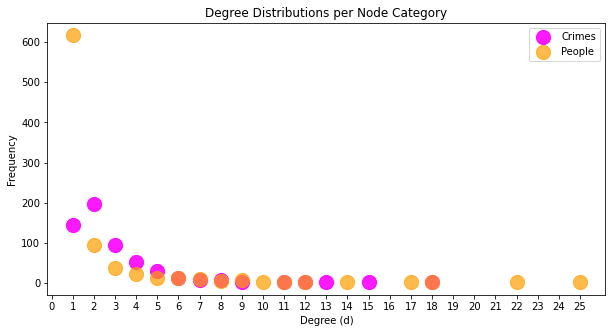

In [33]:
# This includes the entire network
fig, ax = plt.subplots(figsize=(10,5))
ax = plt.gca()
crimes_degree_count.plot(kind = "scatter", x = "Degree (d)", y = "Frequency", color = "#fb00ff", ax = ax, alpha=0.9, s=200)
ppl_degree_count.plot(kind = "scatter", x = "Degree (d)", y = "Frequency", color = "#ff9d00", ax = ax, alpha=0.7, s=200)
ax.legend(["Crimes","People"])
plt.xticks(np.arange(0, 26, step=1))
plt.title("Degree Distributions per Node Category")
plt.show()

## Projected Plots of the Entire Network

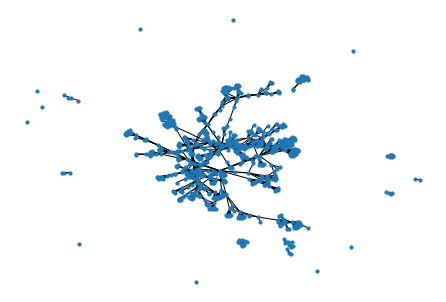

In [34]:
# The Entire Network of People
P_w = bipartite.weighted_projected_graph(G, top_nodes)
nx.draw(P_w, node_size=10)

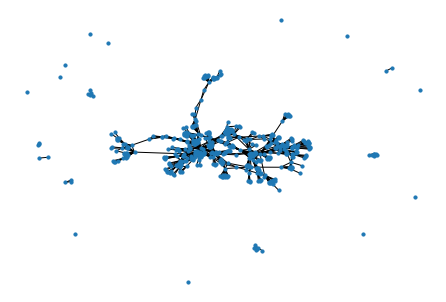

In [35]:
# Entire Network of Crimes
C_w = bipartite.weighted_projected_graph(G, bottom_nodes)
nx.draw(C_w, node_size=10)

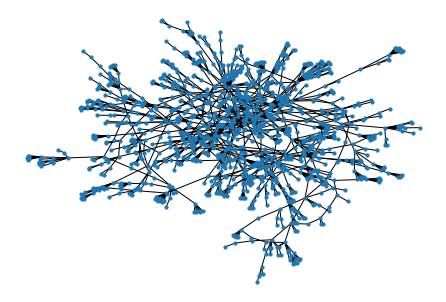

In [36]:
# Plot only biggest component
pos = nx.spring_layout(G0)
posB = nx.bipartite_layout(G0, top_nodes)
biggest_comp_graph = nx.draw(G0, pos, node_size=10)

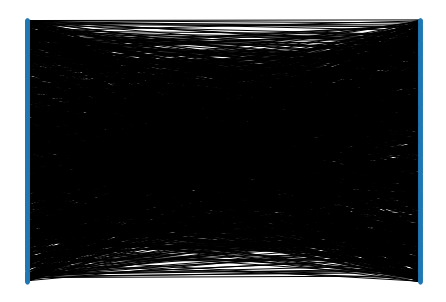

In [37]:
# Biggest component bipartite plot
biggest_comp_graph = nx.draw(G0, posB, node_size=10)

## Projected Graphs from only the LCC

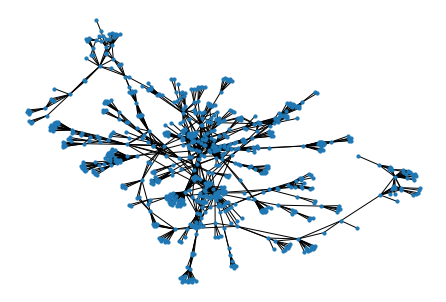

In [38]:
# Just the People from the LCC
P = bipartite.weighted_projected_graph(G0, top_nodes_lcc)
nx.draw(P, node_size=10)

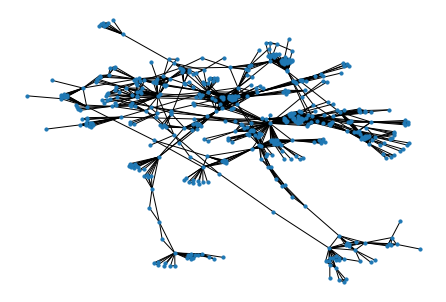

In [39]:
# Only Crimes from the LCC
C = bipartite.weighted_projected_graph(G0, bottom_nodes_lcc)
nx.draw(C, node_size=10)

In [40]:
# Subgraph of Criminals from LCC
# selected just the suspect edges
criminal_edges = [(p,c) for p,c,e in G0.edges(data=True) if nx.get_node_attributes(G0, 'Criminal_Status')[p] == 'Criminal']
# getting all nodes that have suspect edges
sus_nodes = pd.DataFrame(suspect_edges, columns=['node', 'crime']).iloc[:,0].unique()
sus_nodes = set(sus_nodes)

# Create the Graph
GCriminal = G0.edge_subgraph(criminal_edges)

# Visualize The Bipartite Criminal Subgraphs
pos = nx.spring_layout(GCriminal, seed=42)
nx.draw(GCriminal, pos, node_size=10)

NameError: name 'suspect_edges' is not defined

In [ ]:
# Project Criminal Subgraph
# Get people and crime nodes
people_nodes_GS = {n for n, d in GCriminal.nodes(data=True) if d["bipartite"] == 0}
crime_nodes_GS = set(GCriminal) - people_nodes_GS

# Create a new projected graph
weighted_criminal_graph = nx.bipartite.weighted_projected_graph(GCriminal, people_nodes_GS, ratio=False)

# give the number of shared neighbors
weights = list(nx.get_edge_attributes(weighted_criminal_graph, 'weight').values())

nx.draw_spring(weighted_criminal_graph,node_size=10)

In [ ]:
# Subgraph of Innocents from LCC
# selected just the Innocent edges
innocent_edges = [(p,c) for p,c,e in G0.edges(data=True) if nx.get_node_attributes(G0, 'Criminal_Status')[p] == 'Innocent']
# getting all nodes that have suspect edges
inno_nodes = pd.DataFrame(innocent_edges, columns=['node', 'crime']).iloc[:,0].unique()
inno_nodes = set(sus_nodes)

# Create the Graph
GInnocent = G0.edge_subgraph(innocent_edges)

# Visualize The Bipartite Criminal Subgraphs
pos = nx.spring_layout(GInnocent, seed=42)
nx.draw(GInnocent, pos, node_size=10)

In [ ]:
# Project Innocent Subgraph from LCC
# Get people and crime nodes
people_nodes_GS = {n for n, d in GInnocent.nodes(data=True) if d["bipartite"] == 0}
crime_nodes_GS = set(GInnocent) - people_nodes_GS

# Create a new projected graph
weighted_innocent_graph = nx.bipartite.weighted_projected_graph(GInnocent, people_nodes_GS, ratio=False)

# give the number of shared neighbors
weights = list(nx.get_edge_attributes(weighted_innocent_graph, 'weight').values())

nx.draw_spring(weighted_innocent_graph, node_size=10)

# Compare Weight Methods

Based on exercise 23.2, and P. 324 in Network Science

In [ ]:
# We make the code from the previous question into its own function
def simple(network, nodes):
    T = nx.algorithms.bipartite.matrix.biadjacency_matrix(network, row_order = nodes)
    U = T * T.T
    U.setdiag(0)
    U.eliminate_zeros()
    G = nx.from_scipy_sparse_matrix(U)
    return nx.relabel_nodes(G, {i: nodes[i] for i in range(len(nodes))}) 

In [ ]:
# We make functions to calculate alternative projections. The scheme is the same:
# calculate pairwise distances from the bipartite adjacency matrix and make them
# into similarity measures.
def cosine(network, nodes):
    T = nx.algorithms.bipartite.matrix.biadjacency_matrix(network, row_order = nodes)
    # Since this is a distance, we take the inverse to make it into a similarity.
    # Maximum possible cosine distance is 1, so we take one minus it. If the two nodes
    # were identical, this measure equals to 1, if they were the maximum posible far
    # apart, this measure is zero.
    j_dist = 1.0 - pairwise_distances(T, metric = "cosine", n_jobs = -1)
    np.fill_diagonal(j_dist, 0)
    G = nx.from_numpy_matrix(j_dist)
    return nx.relabel_nodes(G, {i: nodes[i] for i in range(len(nodes))})

def pearson(network, nodes):
    T = nx.algorithms.bipartite.matrix.biadjacency_matrix(network, row_order = nodes)
    # Correlation distance maximum is 2 (corresponding to pearson correlation of -1).
    j_dist = (2.0 - pairwise_distances(T.todense(), metric = "correlation", n_jobs = -1)) / 2
    np.fill_diagonal(j_dist, 0)
    # We remove all edges between nodes negatively correlated with each other.
    j_dist[j_dist < .5] = 0
    G = nx.from_numpy_matrix(j_dist)
    return nx.relabel_nodes(G, {i: nodes[i] for i in range(len(nodes))})

In [ ]:
ppl = list(top_nodes)
crimes = list(bottom_nodes)
nodes = ppl

In [ ]:
from sklearn.metrics import pairwise_distances

G_simple = simple(G, nodes)
G_cosine = cosine(G, nodes)
G_pearson = pearson(G, nodes)
all_edges = set(G_simple.edges) | set(G_cosine.edges) | set(G_pearson.edges)

In [ ]:
# The Pearson Correlation of the Cosine and Pearson weights as compared to the simple weights
df = pd.DataFrame(data = [(e,
                           G_simple.edges[e]["weight"] if e in G_simple.edges else 0, 
                           G_cosine.edges[e]["weight"] if e in G_cosine.edges else 0, 
                           G_pearson.edges[e]["weight"] if e in G_pearson.edges else 0)
                         for e in all_edges], columns = ("edge", "simple", "cosine", "pearson"))

df.set_index("edge").corr()

The correlation coefficient of -0.08, in comparing both the cosine similarity and Pearson correlation indicates an insignificant level of negatively correlated. Meaning that there is no statistically significant reason for choosing cosine or pearson correlation for edge weighting above simple edge weighting.

## Degree Distribution Using only the LCC

In [ ]:
# Create DataFrame of People Nodes and their Degree
p_deg_lcc = list(G0.degree(a))
p_deg_lcc = pd.DataFrame(p_deg_lcc, columns = ("Node", "Degree")).sort_values(by = "Node")

# DataFrame of People Node Degrees and their Frequency
p_deg_lcc_count = Counter(dict(G0.degree(a)).values())
p_deg_lcc_count = pd.DataFrame(list(p_deg_lcc_count.items()), columns = ("Degree (d)", "Frequency")).sort_values(by = "Degree (d)")
#p_deg_lcc_count

In [ ]:
# Create DataFrame of Crime Nodes and their Degree
c_deg_lcc = list(G0.degree(b))
c_deg_lcc = pd.DataFrame(c_deg_lcc, columns = ("Node", "Degree")).sort_values(by = "Node")

# Create DataFrame of Crime Node Degrees and their Frequency
c_deg_lcc_count = Counter(dict(G0.degree(b)).values())
c_deg_lcc_count = pd.DataFrame(list(c_deg_lcc_count.items()), columns = ("Degree (d)", "Frequency")).sort_values(by = "Degree (d)")
#crimes_degree_lcc_count

In [ ]:
# This Uses Only the LCC
fig, ax = plt.subplots(figsize=(8,5))
ax = plt.gca()
c_deg_lcc_count.plot(kind = "scatter", x = "Degree (d)", y = "Frequency", color = "#fb00ff", ax = ax, alpha=0.9, s=150)
p_deg_lcc_count.plot(kind = "scatter", x = "Degree (d)", y = "Frequency", color = "#ff9d00", ax = ax, alpha=0.7, s=150)

ax.legend(["Crimes","People"])
plt.xticks(np.arange(0, 26, step=1))
plt.title("Degree Distributions per Node Category Using Only LCC")
#plt.savefig("../Report/degree_distribution_lcc.png")
plt.show()

In [ ]:
# This Uses Only the LCC
fig, ax = plt.subplots(figsize=(8,5)) 
ax = plt.gca()
c_deg_lcc_count.plot(kind = "scatter", loglog=True, x = "Degree (d)", y = "Frequency", color = "#fb00ff", ax = ax, alpha=0.9, s=150)
p_deg_lcc_count.plot(kind = "scatter", loglog=True, x = "Degree (d)", y = "Frequency", color = "#ff9d00", ax = ax, alpha=0.7, s=150)

ax.legend(["Crimes","People"])
plt.title("Degree Distributions per Node Category Using Only LCC")
#plt.savefig("../Report/degree_distribution_loglog_lcc.png")
plt.show()

In [ ]:
# Degree distribution of Both Nodes in LCC
ccdf_lcc = dd_lcc.sort_values(by = "Degree (d)", ascending = False)
ccdf_lcc["cumsum"] = ccdf_lcc["Frequency"].cumsum()
ccdf_lcc["ccdf: P(X>=d)"] = ccdf_lcc["cumsum"] / ccdf_lcc["Frequency"].sum()
ccdf_lcc = ccdf_lcc[["Degree (d)", "ccdf: P(X>=d)"]].sort_values(by = "Degree (d)")

In [ ]:
# Crime Degree Distribution Using Only LCC
c_ccdf = c_deg_lcc_count.sort_values(by = "Degree (d)", ascending = False)
c_ccdf["cumsum"] = c_ccdf["Frequency"].cumsum()
c_ccdf["ccdf: P(X>=d)"] = c_ccdf["cumsum"] / c_ccdf["Frequency"].sum()
c_ccdf = c_ccdf[["Degree (d)", "ccdf: P(X>=d)"]].sort_values(by = "Degree (d)")

In [ ]:
# People Degree Distribution Using Only LCC
p_ccdf = p_deg_lcc_count.sort_values(by = "Degree (d)", ascending = False)
p_ccdf["cumsum"] = p_ccdf["Frequency"].cumsum()
p_ccdf["ccdf: P(X>=d)"] = p_ccdf["cumsum"] / p_ccdf["Frequency"].sum()
p_ccdf = p_ccdf[["Degree (d)", "ccdf: P(X>=d)"]].sort_values(by = "Degree (d)")

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(12,4)) 
ax = plt.gca()

c_ccdf.plot(kind = "line", x = "Degree (d)", y = "ccdf: P(X>=d)", ax=axs[0], color = "#fb00ff", loglog = True)
p_ccdf.plot(kind = "line", x = "Degree (d)", y = "ccdf: P(X>=d)", ax=axs[0], color = "#ff9d00", loglog = True)
axs[0].legend(["Crimes","People"])
axs[0].set_title("CCDF per Node Category Using Only LCC")

ccdf_lcc.plot(kind = "line", x = "Degree (d)", y = "ccdf: P(X>=d)", ax=axs[1], color = "r", loglog = True)
axs[1].legend(["Both Nodes Combined"])
axs[1].set_title("CCDF For All Nodes in LCC")


plt.show()

## Fit CCDF to PowerLaw

In [ ]:
logcdf_lcc = np.log10(ccdf_lcc[["Degree (d)", "ccdf: P(X>=d)"]])
slope, log10intercept, r_value, p_value, std_err = linregress(logcdf_lcc["Degree (d)"], logcdf_lcc["ccdf: P(X>=d)"])
print("CCDF Fit: %1.4f x ^ %1.4f (R2 = %1.4f, p = %1.4f)" % (10 ** log10intercept, slope, r_value ** 2, p_value))
print("\n")

results = pl.Fit(ccdf_lcc["ccdf: P(X>=d)"])
k_min = ccdf_lcc[ccdf_lcc["ccdf: P(X>=d)"] == results.power_law.xmin]["Degree (d)"]
print("Powerlaw CCDF Fit: %1.4f x ^ -%1.4f (k_min = %d)" % (10 ** results.power_law.Kappa, results.power_law.alpha, k_min))

In [ ]:
# Plot the best fit.
ccdf_lcc["fit"] = (10 ** results.power_law.Kappa) * (ccdf_lcc["Degree (d)"] ** -results.power_law.alpha)
ax = plt.gca()
ccdf_lcc.plot(kind = "line", x = "Degree (d)", y = "ccdf: P(X>=d)", color = "#e41a1c", loglog = True, ax = ax)
ccdf_lcc.plot(kind = "line", x = "Degree (d)", y = "fit", color = "#377eb8", loglog = True, ax = ax)
#plt.savefig("../Report/ccdf_lcc_fit.png")
plt.show()

# Adjacency Matrix

Central Place Theory.
Chapter 29 in the book.

The Adjacency matrix of our LCC looks like a discrete model. Which imposes a strict core-periphery structure. This also does not seem to show any smaller communities extending off of the core.

In [ ]:
# Get the degrees of the nodes
degree = dict(G0.degree)

# Figure out which node is of which type
rows, cols = nx.algorithms.bipartite.sets(G0)

# Sort rows and columns according to their degree
rows = {n: degree[n] for n in rows}
cols = {n: degree[n] for n in cols}
rows = [n[0] for n in sorted(rows.items(), key = lambda x : x[1], reverse = True)]
cols = [n[0] for n in sorted(cols.items(), key = lambda x : x[1], reverse = True)]

In [ ]:
# Get the biadjacency matrix with the properly sorted rows and columns
B = nx.algorithms.bipartite.matrix.biadjacency_matrix(G0, rows, column_order = cols)
plt.figure(figsize=(4,10))
plt.spy(B, markersize = 3)
plt.show()

# Finding Which Nodes Connect to Which Cores

https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.core.core_number.html#networkx.algorithms.core.core_number

In [ ]:
c_whole = nx.algorithms.core.core_number(G)
c_whole_count = Counter(c_whole.values())
c_whole_count

In [ ]:
c = nx.algorithms.core.core_number(G0)
count_c = Counter(c.values())
count_c
print(f"Core 1 has {count_c[1]} Nodes attached \nCore 2 has {count_c[2]} Nodes \nCore 3 has {count_c[3]} Nodes")

# Edge-Centric Plot

Based on Exercise 27.1

https://www.networkatlas.eu/exercise.htm?c=27&e=1

look for how to put a colorbar

In [ ]:
# Get the degrees of the nodes
degrees = dict(G0.degree)

# Edge-centric plot
edge_assort = [(degrees[e[0]], degrees[e[1]]) for e in G0.edges]
edge_assort = pd.DataFrame(data = edge_assort, columns = ("k1", "k2"))
edge_assort = edge_assort.groupby(by = ["k1", "k2"]).size().reset_index().rename(columns = {0: "count"}).sort_values(by = "count")

# Taking the log count of edges with nodes with the same degrees
edge_assort["count"] = np.log(edge_assort["count"])

In [ ]:
# Plotting the edge-centric plot
ax = plt.gca()
plt.scatter(edge_assort["k1"], edge_assort["k2"], c = edge_assort["count"], cmap = "Reds")
ax.set_yscale("log")
ax.set_xscale("log")

plt.show()

In [ ]:
# Let's make a new figure
plt.clf()

# Two vectors with the degree of a node in one, and the average neighbor degree in the other
node_assort = [(degrees[n], degrees[n2]) for n in G0.nodes for n2 in G0.neighbors(n)]
node_assort = pd.DataFrame(data = node_assort, columns = ("k", "neigh_k"))
node_assort = node_assort.groupby(by = "k").mean().reset_index()

In [ ]:
# Plotting the node-centric plot
ax = plt.gca()
plt.scatter(node_assort["k"], node_assort["neigh_k"])
ax.set_yscale("log")
ax.set_xscale("log")
plt.show()

In [ ]:
# Let's make two vectors with the degrees at each endpoints of edges
x1 = []
y1 = []
for e in G0.edges:
    x1.append(degrees[e[0]])
    y1.append(degrees[e[1]])
    x1.append(degrees[e[1]])
    y1.append(degrees[e[0]])

In [ ]:
from scipy.stats import pearsonr, linregress

# Edge-centric assortativity is the pearson correlation of such vectors
r, p = pearsonr(x1, y1)
print("Degree assortativity coefficient: %1.4f (p-value < 0.001? %s)" % (r, p < 0.001))

In [ ]:
# Node-centric assortativity is the power-fit of such vectors
slope, intercept, r_value, p_value, std_err = linregress(np.log(node_assort["k"]), np.log(node_assort["neigh_k"]))
print("Degree assortativity coefficient: %1.4f (p-value < 0.001? %s)" % (slope, p_value < 0.001))

# Configuration Model

P. 323 in Network Science:
One can define a series of null bipartite network models... via ... a configuration model. These null models will give birth to a bunch of null projections, which will give an expected weight for all possible edges in the unipartite network. Then, you can keep in your projection only those links significantly exceeding random expectation.

In [ ]:
# To compare to a null model based on the LCC, unipartite
G0degrees = list(dict(G0.degree).values())
CM = nx.configuration_model(G0degrees)
#nx.draw(CM, node_size=10)

In [ ]:
# A bipartite configuration model based on the entire dataset
BiCM = nx.algorithms.bipartite.generators.configuration_model(e_p, e_c) # imputs are the degrees of each node
#nx.draw(Bi_CM, node_size=10)

# Find the LCC
# Sort the connected components
cc_BiCM = sorted(nx.connected_components(BiCM), key=len, reverse=True)

# Select the biggest component
GCC_BiCM = BiCM.subgraph(cc_BiCM[0])

#nx.draw(G0_BiCM, node_size=10)

# Create lists of nodes for the LCC
people_gcc_BiCM = {n for n, d in GCC_BiCM.nodes(data=True) if d["bipartite"] == 0} # people
crimes_gcc_BiCM = set(GCC_BiCM) - people_gcc_BiCM  # crimes

print(f"The BiCM is bipartite? {bipartite.is_bipartite(BiCM)}")
print("WHY THE FUCK WON'T THIS WORK?!!!!")

#people_gcc_BiCM

# Project This onto the People Nodes... how do do this?
P_BiCM = bipartite.weighted_projected_graph(GCC_BiCM, people_gcc_BiCM)
#nx.algorithms.bipartite.projection.projected_graph(GCC_BiCM, people_gcc_BiCM, multigraph=True)
#plt.rcParams.update({'figure.figsize': (20, 10)})
#pos = nx.spring_layout(P_BiCM, seed=42)
#nx.draw_networkx(P_BiCM, pos, node_size=20, with_labels=False)

In [ ]:
# A bipartite that is only the LCC
Bi_CM_0 = nx.algorithms.bipartite.generators.configuration_model(e_p1, e_c1)
#nx.draw(Bi_CM_0, node_size=10)

# Project the BiCM generated network
#Proj_BiCM = bipartite.weighted_projected_graph(Bi_CM_0, e_p1)
#nx.draw(Proj_BiCM, node_size=10)

In [ ]:
# Configuration model based on the projection of people
P_nodes_projected = list(dict(P.degree).values())
P_CM = nx.configuration_model(P_nodes_projected)
nx.draw(P_CM, node_size=10)

# Checking for Assortativity (Homophily) of Gender

### *Assortativity measures the similarity of connections in the graph with respect to the given attribute. Perfect assortativity is 1, while perfect disassortativity is -1. The whole network is quite disassortative.*

In [ ]:
# Assortativity coefficient of the Entire Network
nx.attribute_assortativity_coefficient(G, "sex")

In [ ]:
# Assortativity coefficient of the LCC
nx.attribute_assortativity_coefficient(G0, "sex")

In [ ]:
# Assortativity coefficient of the projected network
nx.attribute_assortativity_coefficient(P, "sex")

## Checking Assortativity of Criminal_status

In [ ]:
# Assortativity coefficient of the projected people network (based on the LCC of the entire network)
nx.attribute_assortativity_coefficient(P, "Criminal_Status")

#### More powerlaw stuff

In [ ]:
#  Use the power law (f function) with its logarithm (log_f), to fit it to the log of the CCDF in curve_fit. This
# is done because we want to minimize the relative error, not the absolute error (since the tail of the 
# distribution is very important, but it contributes very little to the absolute error).

#popt, pcov = curve_fit(log_f, ccdf_lcc["Degree (d)"], np.log10(ccdf_lcc["ccdf: P(X>=d)"]), p0 = (1, 1))
#ccdf_lcc["fit"] = ccdf_lcc.apply(lambda x: f(x["Degree (d)"], popt[0], popt[1]), axis = 1)

#ax = plt.gca()
#ccdf_lcc.plot(kind = "line", x = "Degree (d)", y = "ccdf: P(X>=d)", color = "#e41a1c", loglog = True, ax = ax)
#ccdf_lcc.plot(kind = "line", x = "Degree (d)", y = "fit", color = "#377eb8", loglog = True, ax = ax)
#plt.savefig("../Report/ccdf_lcc_fit_2.png")
#plt.show()

### Non-square adjacency matrix, and stocastic matrix

In [ ]:
# Non-square adjacency matrix
adjmat = nx.algorithms.bipartite.matrix.biadjacency_matrix(G, top_nodes)
print(adjmat.shape)

In [ ]:
# Project along smaller axis
if adjmat.shape[0] == 551:
    adjmat_proj = adjmat.dot(adjmat.T)
else:
    adjmat_proj = adjmat.T.dot(adjmat)

In [ ]:
# Make stocastic
adjmat_proj_stoc = adjmat_proj / adjmat_proj.sum(axis = 1)
print(adjmat_proj_stoc.shape)

# Community Detection

In [ ]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import networkx.algorithms.community as comms
class Dunno:
    
    def __init__ (self, G, POI='p1', highlight=0, Gcc=True):
        
        if Gcc:
            comp_list = sorted(nx.connected_components(G), key=len, reverse=True)
            self.G = G.subgraph(comp_list[0])
        else:
            self.G = G
        self.POI = POI
        self.highlight = highlight
        self.communities = sorted(comms.greedy_modularity_communities(self.G), key=len, reverse=True)
        self.modularity = comms.modularity(self.G, self.communities)
        self.p_nodes = []
        self.c_nodes = []
        for node in self.G.nodes:
            if 'p' in node:
                self.p_nodes.append(node)
            else:
                self.c_nodes.append(node)
                
        if len(self.c_nodes) == 0:
            self.proj = self.G
            self.isproj=True
            print('This graph only has people in it, no crimes')
        else:
            self.proj = bipartite.weighted_projected_graph(self.G, self.p_nodes)
            self.isproj=False
        
    def com_find(self, proj=False):
        if proj:
            self.communities = sorted(comms.greedy_modularity_communities(self.proj), key=len, reverse=True)
            self.modularity = comms.modularity(self.proj, self.communities)
            
        print(f"There are {len(self.communities)} communities.")
        found = False
        for i in range(len(self.communities)):
            if self.POI in self.communities[i]:
                print(f'The POI is in community {i}')
                found = True
                self.highlight = i #sets the POI's community to be highlighted in graphs below
        if not found:
            print(f'POI not found in this component, highlight defaults to {highlight}')
    
    def com_plot(self, save=False, plot_st = 0, plot_end=100, fig=(20,15), col='blue'):
        a = min(plot_end, len(self.communities))
        b = a//5
        if b == 0:
            b=1
        
        fig, ax = plt.subplots(figsize=fig)
        fig.tight_layout()
        
        
        for i in range(plot_st,a): 
            com = self.proj.subgraph(self.communities[i])
            print(i, len(com.nodes), len(com.edges))

            plt.subplot(b,5,i+1)
            nx.draw_spring(com, node_size=40, node_color=col)
        if save:
            plt.savefig(f'../Figures/communities.jpg')
        
    def high_com(self, proj=False, hi_col = 'red', oth_col='blue', crime_col = 'green', save=False):
        node_col = []
        if proj:
            G = self.proj
        else:
            G = self.G
            
        for node in G.nodes():
            if node in self.c_nodes:
                node_col.append(crime_col)
            elif node in self.communities[self.highlight]:
                node_col.append(hi_col)
            else:
                node_col.append(oth_col)

        
        plt.rcParams.update({'figure.figsize': (30, 20)})
        pos = nx.spring_layout(G, seed=23)

        nx.draw_networkx(G, pos,
                         node_size=80,
                         node_color=node_col,
                         with_labels=False)
        
        hi_patch = mpatches.Patch(color=hi_col, label=f'Community {self.highlight}')
        oth_patch = mpatches.Patch(color=oth_col, label=f'All other nodes')
        cri_patch = mpatches.Patch(color=crime_col, label=f'Crime nodes')
        if len(c_nodes) > 0 and not proj:
            hand = [hi_patch, oth_patch, cri_patch]
        else: 
            hand = [hi_patch, oth_patch]
        plt.legend(handles=hand, fontsize='xx-large')
         
        if save:
            plt.savefig(f'../Figures/community_{self.highlight}_highlight.jpg')
            
    def labled_comm(self, POI_col='aqua', male_col='blue', 
                    female_col='magenta', crime_col='green',
                   vic_col='blue', sus_col='red',
                    wit_col='green', other_col='black', save=False):
        ed = []
        lab = {}
        hand1 = []
        hand2 = []
        
        POI_patch = mpatches.Patch(color=POI_col, label=f'POI node')
        male_patch = mpatches.Patch(color=male_col, label=f'Male node')
        female_patch = mpatches.Patch(color=female_col, label=f'Female node')
        crime_patch = mpatches.Patch(color=crime_col, label=f'Crime node')
        
        vic_line = mlines.Line2D([], [], color=vic_col, label='Victim role')
        sus_line = mlines.Line2D([], [], color=sus_col, label='Suspect role')
        wit_line = mlines.Line2D([], [], color=wit_col, label='Witness role')
        other_line = mlines.Line2D([], [], color=other_col, label='Dual role')
        
        for per in self.communities[self.highlight]:
            if 'p' in per:
                lab[per] = (f"{nx.get_node_attributes(self.G, 'first')[per]} {nx.get_node_attributes(self.G, 'last')[per]} \n({per})")
                if self.isproj == False:
                    for c in self.G.edges([per]):
                        ed.append(c[1])
                        lab[c[1]] = f'{c[1]}'
            else:
                lab[per] = f'{per}'

        for i in self.communities[self.highlight]:
            ed.append(i)
  
        nc = []
        ec = []

        hi = self.G.subgraph(ed)

        for node in hi:
            if node in self.c_nodes:
                nc.append(crime_col)
                hand1.append(crime_patch)
            elif node in self.communities[self.highlight]:
                if node == POI:
                    nc.append(POI_col)
                    hand1.append(POI_patch)
                elif nx.get_node_attributes(self.G, 'sex')[node] == '1':
                    nc.append(male_col)
                    hand1.append(male_patch)
                else:
                    nc.append(female_col)
                    hand1.append(female_patch)
            else:
                nc.append('yellow') #none should ever show yellow!! something is wrong if they do
        
        if self.isproj==False:
            for edge in hi.edges():
                a = nx.get_edge_attributes(hi, 'role')[edge]
                if a == 'Victim':
                    ec.append(vic_col)
                    hand2.append(vic_line)
                elif a == 'Suspect':
                    ec.append(sus_col)
                    hand2.append(sus_line)
                elif a == 'Witness':
                    ec.append(wit_col)
                    hand2.append(wit_line)
                else:
                    ec.append(other_col)
                    hand2.append(other_line)
        else:
            ec = other_col

        hand = list(set(hand1)) + (list(set(hand2)))
        plt.rcParams.update({'figure.figsize': (25, 25)})
        pos = nx.spring_layout(hi, weight=None, k=0.2, seed=23)

        nx.draw_networkx(hi, pos, node_size=200, node_color=nc, edge_color=ec, labels=lab)
        plt.legend(handles=hand, fontsize='xx-large')
        if save:
            plt.savefig(f'../Figures/community_{self.highlight}_focus.jpg')



In [ ]:
bet_centrality = nx.betweenness_centrality(P, normalized = True, 
                                              endpoints = False)
bet_cent_list = sorted(bet_centrality.values(), reverse=True)

for k,v in bet_centrality.items():
    if v == bet_cent_list[0]:
        print(f"POI is set to '{k}'")
        POI = k

#POI = 'p56' #set a Person of Interest if not using the highest betweeness centrality person
thing = Dunno(G, POI) # will default to using the largest connected component unless you state Gcc=False

thing.com_find(proj=True) # set proj=True if you want to find communities for the people projection, else it will use the entire graph you gave it. 
#print(f'Modularity of network communities: {thing.modularity}')
#thing.com_plot(plot_end=10, col='blue') 

#thing.high_com(hi_col='magenta',oth_col='aqua',) # use proj=True to draw the projected graph, or defaults to drawing the whole graph
thing.labled_comm()

In [ ]:
thing.isproj

In [ ]:
print(nx.get_node_attributes(G, 'sex')['p583'])

In [ ]:
# Check homophily of Criminal_status
comm_cs = []
for community in thing.communities:
    print(len(community))
    #print(nx.attribute_assortativity_coefficient(community, "Criminal_Status"))

In [ ]:
# project onto people and visualise
P2 = bipartite.weighted_projected_graph(G0, top_nodes_lcc)

print('C',len(P2.nodes()), len(P2.edges()))

plt.rcParams.update({'figure.figsize': (30, 20)})
pos = nx.spring_layout(P2, seed=23)
#nx.draw_networkx(P2, pos, node_size=60, with_labels=False)

In [ ]:
# Find communities in the projected people network
communities_p = sorted(comms.greedy_modularity_communities(P2, weight='weight'), key=len, reverse=True) #14 coms modularity 0.813

# Count the communities
print(f"There are {len(communities_p)} communities.")

comms.modularity(P2, communities_p)

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
fig.tight_layout()

for i in range(0,10): 
    com = P2.subgraph(communities_p[i])
    node_col = []
    for node in com.nodes():
        a = nx.get_node_attributes(com, 'Criminal_Status')[node]
        if a == 'Criminal':
            node_col.append('red')
        else:
            node_col.append('blue')
    print(i, len(com.nodes))
    plt.subplot(2,5,i+1)
    nx.draw_spring(com, node_size=40, node_color=node_col) #, with_labels=True
#plt.savefig(f'../Figures/1-10_C_community.jpg')

In [ ]:
# Plot the LCC with Criminals and Victims Color coded
pos = nx.spring_layout(G0)
plt.figure(3,figsize=(16,16))
color_map = []
edge_cm = []
for node in G0:
    if node.startswith('p'):
        a = nx.get_node_attributes(G0, 'Criminal_Status')[node]
        if a == 'Criminal':
            color_map.append('red')
        else:
            color_map.append('blue')
    else:
        color_map.append('black')


        
nx.draw(G0,pos, node_color=color_map, with_labels = False, node_size = 40, width = 0.5)
plt.show()
